In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import tqdm

In [5]:
def calc_length(arr):
    res = 0
    for s in (0, 4):
        res += ((arr[s] - arr[s + 2]) ** 2 +
                (arr[s + 1] - arr[s + 3]) ** 2)
    return res


def min_length(arr):
    res = 100
    arr = arr[:8]
    #numpyに
    arr = np.array(arr)
    for s in (0,4):
        res = min(res, (arr[s] - arr[s + 2]) ** 2 +
                  (arr[s + 1] - arr[s + 3]) ** 2)
    print(f"\r{res}",end="")
    return res

def cherry_pick(df,threshold=10):
    # data[:8]のmin_lengthが10未満のものをdrop
    df = df.apply(lambda x: min_length(x) >= threshold, axis=0)



#memo: 長さを固定して、出発地点・角度(rad)を2値にする？

2.3665253307230564e-06

C:\Users\Dette\AppData\Local\Temp\ipykernel_13604\837478395.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  arr = arr[:8]


Epoch 1/500
200/200 [==============================] - 5s 24ms/step - loss: 0.7181 - mse: 0.7181 - val_loss: 0.6390 - val_mse: 0.6390
Epoch 2/500
200/200 [==============================] - 1s 5ms/step - loss: 0.5802 - mse: 0.5802 - val_loss: 0.6090 - val_mse: 0.6090
Epoch 3/500
200/200 [==============================] - 1s 5ms/step - loss: 0.5122 - mse: 0.5122 - val_loss: 0.5843 - val_mse: 0.5843
Epoch 4/500
200/200 [==============================] - 1s 4ms/step - loss: 0.4601 - mse: 0.4601 - val_loss: 0.5744 - val_mse: 0.5744
Epoch 5/500
200/200 [==============================] - 1s 4ms/step - loss: 0.4108 - mse: 0.4108 - val_loss: 0.5775 - val_mse: 0.5775
Epoch 6/500
200/200 [==============================] - 1s 4ms/step - loss: 0.3681 - mse: 0.3681 - val_loss: 0.5677 - val_mse: 0.5677
Epoch 7/500
200/200 [==============================] - 1s 4ms/step - loss: 0.3289 - mse: 0.3289 - val_loss: 0.5615 - val_mse: 0.5615
Epoch 8/500
200/200 [==============================] - 1s 4ms/step -

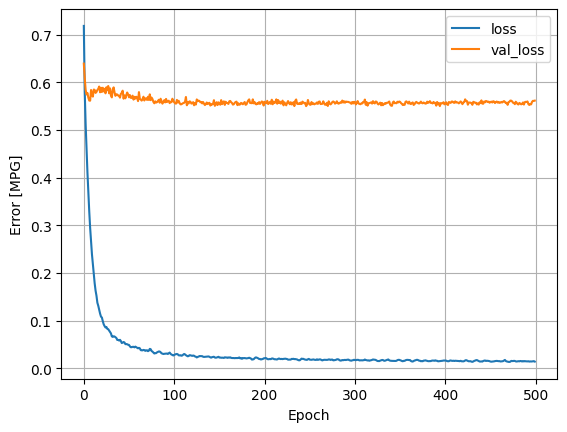

In [6]:
prefix = "new30"
for i in range(10):
    filename = f"{prefix}/{prefix}_{i}.csv"
    # csvファイルの読み込み
    if i == 0:
        df = pd.read_csv(filename, header=0)
        df = df.drop("Unnamed: 0", axis=1)
    else:
        tmp = pd.read_csv(filename, header=0)
        tmp = tmp.drop("Unnamed: 0", axis=1)
        df = pd.concat([df, tmp], axis=0)

cherry_pick(df)


#dataframeをnumpy配列に変換
data = df.values
#深層学習の入力データと出力データに分ける
# 入力データ
len_test = 8
x = data[:, len_test:]

# 出力データ
y = data[:, :len_test]
#入力データの正規化
x = (x - x.mean()) / x.std()


#出力データのMin-Max正規化
y = (y - y.min()) / (y.max() - y.min())

#入力データの次元数
input_dim = x.shape[1]

#出力データの次元数
output_dim = y.shape[1]

#入力データの数
n = x.shape[0]

# 出力データ
y = data[:, :len_test]
#入力データの正規化
x = (x - x.mean()) / x.std()

#出力データの正規化
y = (y - y.mean()) / y.std()

#入力データの次元数
input_dim = x.shape[1]

#出力データの次元数
output_dim = y.shape[1]

#入力データの数
n = x.shape[0]

#学習データとテストデータに分ける
#学習データ
x_train = x[:int(n*0.8)]
y_train = y[:int(n*0.8)]

#テストデータ
x_test = x[int(n*0.8):]
y_test = y[int(n*0.8):]

# モデルの定義 
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(201, activation='relu', input_shape=(input_dim,)),
    # ドロップアウト
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(236, activation='relu', input_shape=(input_dim,)),
    #ドロップアウト
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(150, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(output_dim)
])

def compile():
    #モデルのコンパイル
    model.compile(optimizer='adam',
                    loss='mse',
                    metrics=['mse'])

    #モデルの学習
    history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_split=0.2)

    #学習の様子をグラフに描画
    #損失関数の値
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')


    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')

    plt.legend()
    plt.grid(True)

    #表示
    plt.show()
    return model,history

model,history = compile()


In [7]:

def objective(trial):
    # ハイパーパラメータのサンプリング
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []
    for i in range(n_layers):
        n_units = trial.suggest_int('n_units_l{}'.format(i), 8, 256)
        layers.append(tf.keras.layers.Dense(n_units, activation='relu'))
    layers.append(tf.keras.layers.Dense(output_dim))
    model = tf.keras.models.Sequential(layers)

    # モデルのコンパイル
    model.compile(optimizer='adam',
                loss='rmse',
                metrics=['mse'])

    # モデルの学習
    history = model.fit(x_train, y_train, epochs=1000, batch_size=32, validation_split=0.2)

    # 損失関数の値
    return history.history['val_loss'][-1]


# チューニングを行う

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)


In [8]:
#1行目の値を実際に計算
print(model.predict(x_test[:1]))
#実際の値
print(y_test[:1])

1/1 [==============================] - 0s 86ms/step
[[-0.43889177  1.02085     0.5219689  -0.52302784  0.21971996 -0.02781768
  -0.41415468  0.44776008]]
[[-1.3134483   0.72089496  0.36189321 -0.59544479 -1.0741138   1.43889847
  -0.71511204  0.60122771]]


In [9]:
# 片対数プロット

plt.plot(history["loss"], label="loss")
plt.plot(history["val_loss"], label="val_loss")
# plotの上限を設定
plt.ylim(0, 1)
plt.legend()
ax = plt.gca()

# 軸ラベルを追加
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

plt.show()


NameError: name 'history' is not defined

In [ ]:
# modelの保存
prefix = "neural"
model.save(f"models/{prefix}.h5")
# 学習経過の保存
history_df = pd.DataFrame(history.history)
history_df.to_csv(f"models/{prefix}.csv")
